In [ ]:
classes = [
    "art_nouveau",
    "baroque",
    "expressionism",
    "impressionism",
    "post_impressionism",
    "realism",
    "renaissance",
    "romanticism",
    "surrealism",
    "ukiyo_e"
    ]
train_path = "/content/dataset/classification_train"
# test_path = "/content/dataset/classification_test_part"
test_path = "/content/drive/MyDrive/classification_test_part"
drive_train_path = "/content/drive/MyDrive/classification_train"
drive_test_path = "/content/drive/MyDrive/classification_test_part"

In [ ]:
# Mount the drive
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Move data to local environment
import os
import shutil

os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
shutil.copytree(drive_train_path, train_path, dirs_exist_ok=True)
shutil.copytree(drive_test_path, test_path, dirs_exist_ok=True)

KeyboardInterrupt: 

In [ ]:
# Copy a subset of images for training
import os
import shutil
import random

full_train_files = "/content/drive/MyDrive/classification_train"
full_test_files = "/content/drive/MyDrive/classification_test"

nr_of_train_img = 1000
nr_of_test_img = 200

def split_image_part(class_name, full_files, part_files, nr_to_split):
    class_folder = os.path.join(full_files, class_name.lower())

    images = [img for img in os.listdir(class_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    images = images[:nr_to_split]

    for img in images:
        old_path = os.path.join(class_folder, img)
        new_class_folder = os.path.join(part_files, class_name.lower())
        os.makedirs(new_class_folder, exist_ok=True)
        new_path = os.path.join(new_class_folder, img)
        shutil.copy(old_path, new_path)

for class_name in classes:
    # split_image_part(class_name, full_train_files, train_path, nr_of_train_img)
    split_image_part(class_name, full_test_files, test_path, nr_of_test_img)
    print("Copied class: " + class_name)

KeyboardInterrupt: 

In [ ]:
# Create image transformation
import torch
import torchvision
from torchvision.transforms import transforms

transform = transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(30),
    transforms.ToTensor()
])

In [ ]:
# Prepare the loaders
from torchvision import datasets
from torch.utils.data import DataLoader

batch_size = 32
test_batch_size = 16
train_dataset = datasets.ImageFolder(train_path, transform = transform)
val_dataset = datasets.ImageFolder(test_path, transform = transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, num_workers=2)

FileNotFoundError: [Errno 2] No such file or directory: '/content/dataset/classification_train'

In [ ]:
# Define the model

import torch
import torch.nn as  nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)



def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [ ]:
import torch
from tqdm import tqdm
import torch.nn.functional as Funtional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(10, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

save_dir = '/content/drive/MyDrive/checkpointsStyles2'
os.makedirs(save_dir, exist_ok=True)

best_val_loss = float('inf')
num_epochs = 100

patience = 15
counter = 0
early_stop = False

for epoch in range(num_epochs):
  if early_stop:
    print("Early stopping.")
    break

  train_loss = 0.0
  model.train()
  for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, Funtional.one_hot(labels, num_classes=10).float())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)

  val_loss = 0.0
  model.eval()
  with torch.no_grad():
      for images, labels in val_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, Funtional.one_hot(labels, num_classes=10).float())
          val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)

  print(f"Epoch {epoch+1}: Train Loss={train_loss/len(train_loader):.4f}, Val Loss={val_loss/len(val_loader):.4f}")

  if (epoch + 1) % 10 == 0:
      checkpoint_path = os.path.join(save_dir, f"model_epoch_{epoch+1}.pth")
      torch.save(model.state_dict(), checkpoint_path)
      print(f"Saved checkpoint: {checkpoint_path}")

  if avg_val_loss < best_val_loss:
      counter = 0
      best_val_loss = avg_val_loss
      best_model_path = os.path.join(save_dir, "best_model.pth")
      torch.save(model.state_dict(), best_model_path)
      print(f"Saved best model so far at epoch {epoch+1}")
  else:
      counter += 1

      if counter >= patience:
          early_stop = True

Epoch 0: 100%|██████████| 1564/1564 [04:28<00:00,  5.82it/s]


Epoch 1: Train Loss=1.9659, Val Loss=1.9671
Saved best model so far at epoch 1


Epoch 1: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 2: Train Loss=1.7853, Val Loss=1.8683
Saved best model so far at epoch 2


Epoch 2: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 3: Train Loss=1.6951, Val Loss=1.7296
Saved best model so far at epoch 3


Epoch 3: 100%|██████████| 1564/1564 [04:27<00:00,  5.85it/s]


Epoch 4: Train Loss=1.6254, Val Loss=1.6632
Saved best model so far at epoch 4


Epoch 4: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 5: Train Loss=1.5666, Val Loss=1.5562
Saved best model so far at epoch 5


Epoch 5: 100%|██████████| 1564/1564 [04:27<00:00,  5.85it/s]


Epoch 6: Train Loss=1.5167, Val Loss=1.5903


Epoch 6: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 7: Train Loss=1.4715, Val Loss=1.7561


Epoch 7: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 8: Train Loss=1.4378, Val Loss=1.5303
Saved best model so far at epoch 8


Epoch 8: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 9: Train Loss=1.4070, Val Loss=1.5910


Epoch 9: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 10: Train Loss=1.3726, Val Loss=1.4630
Saved checkpoint: /content/drive/MyDrive/checkpointsStyles2/model_epoch_10.pth
Saved best model so far at epoch 10


Epoch 10: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 11: Train Loss=1.3497, Val Loss=1.4198
Saved best model so far at epoch 11


Epoch 11: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 12: Train Loss=1.3256, Val Loss=1.6103


Epoch 12: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 13: Train Loss=1.2991, Val Loss=1.4346


Epoch 13: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 14: Train Loss=1.2779, Val Loss=1.3371
Saved best model so far at epoch 14


Epoch 14: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 15: Train Loss=1.2562, Val Loss=1.4377


Epoch 15: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 16: Train Loss=1.2334, Val Loss=1.3561


Epoch 16: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 17: Train Loss=1.2126, Val Loss=1.3530


Epoch 17: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 18: Train Loss=1.1982, Val Loss=1.4119


Epoch 18: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 19: Train Loss=1.1731, Val Loss=1.3737


Epoch 19: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 20: Train Loss=1.1585, Val Loss=1.3134
Saved checkpoint: /content/drive/MyDrive/checkpointsStyles2/model_epoch_20.pth
Saved best model so far at epoch 20


Epoch 20: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 21: Train Loss=1.1402, Val Loss=1.3731


Epoch 21: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 22: Train Loss=1.1244, Val Loss=1.3437


Epoch 22: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 23: Train Loss=1.1061, Val Loss=1.3177


Epoch 23: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 24: Train Loss=1.0919, Val Loss=1.4206


Epoch 24: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 25: Train Loss=1.0727, Val Loss=1.2540
Saved best model so far at epoch 25


Epoch 25: 100%|██████████| 1564/1564 [04:27<00:00,  5.85it/s]


Epoch 26: Train Loss=1.0526, Val Loss=1.2946


Epoch 26: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 27: Train Loss=1.0377, Val Loss=1.2871


Epoch 27: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 28: Train Loss=1.0228, Val Loss=1.3408


Epoch 28: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 29: Train Loss=1.0052, Val Loss=1.4188


Epoch 29: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 30: Train Loss=0.9861, Val Loss=1.3968
Saved checkpoint: /content/drive/MyDrive/checkpointsStyles2/model_epoch_30.pth


Epoch 30: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 31: Train Loss=0.9707, Val Loss=1.3595


Epoch 31: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 32: Train Loss=0.9503, Val Loss=1.3558


Epoch 32: 100%|██████████| 1564/1564 [04:28<00:00,  5.82it/s]


Epoch 33: Train Loss=0.9316, Val Loss=1.3858


Epoch 33: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 34: Train Loss=0.9171, Val Loss=1.3455


Epoch 34: 100%|██████████| 1564/1564 [04:28<00:00,  5.84it/s]


Epoch 35: Train Loss=0.9034, Val Loss=1.4140


Epoch 35: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 36: Train Loss=0.8791, Val Loss=1.2970


Epoch 36: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 37: Train Loss=0.8643, Val Loss=1.3509


Epoch 37: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 38: Train Loss=0.8443, Val Loss=1.3360


Epoch 38: 100%|██████████| 1564/1564 [04:27<00:00,  5.84it/s]


Epoch 39: Train Loss=0.8206, Val Loss=1.3557


Epoch 39: 100%|██████████| 1564/1564 [04:28<00:00,  5.83it/s]


Epoch 40: Train Loss=0.8054, Val Loss=1.3637
Saved checkpoint: /content/drive/MyDrive/checkpointsStyles2/model_epoch_40.pth
Early stopping.


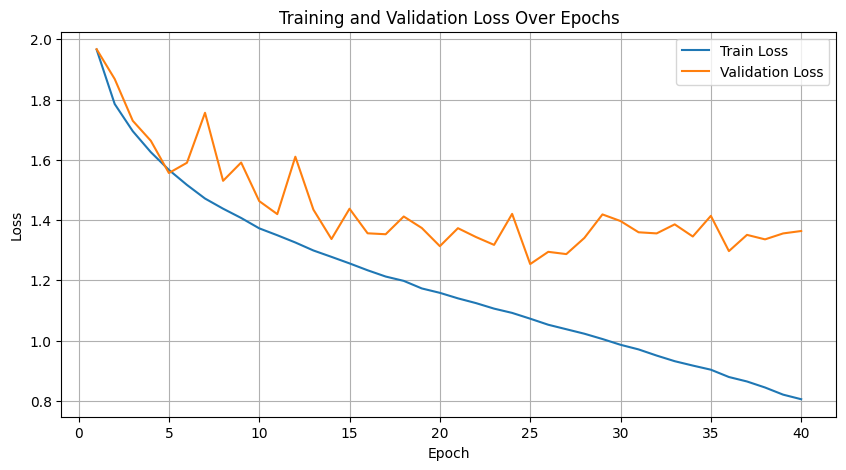

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = [1.9659, 1.7853, 1.6951, 1.6254, 1.5666, 1.5167, 1.4715, 1.4378, 1.4070, 1.3726, 1.3497, 1.3256, 1.2991, 1.2779, 1.2562, 1.2334, 1.2126, 1.1982, 1.1731, 1.1585, 1.1402, 1.1244, 1.1061, 1.0919, 1.0727, 1.0526, 1.0377, 1.0228, 1.0052, 0.9861, 0.9707, 0.9503, 0.9316, 0.9171, 0.9034, 0.8791, 0.8643, 0.8443, 0.8206, 0.8054]
val_losses = [1.9671,1.8683,1.7296,1.6632,1.5562,1.5903,1.7561,1.5303,1.5910,1.4630,1.4198,1.6103,1.4346,1.3371,1.4377,1.3561,1.3530,1.4119,1.3737,1.3134,1.3731,1.3437,1.3177,1.4206,1.2540,1.2946,1.2871,1.3408,1.4188,1.3968,1.3595,1.3558,1.3858,1.3455,1.4140,1.2970,1.3509,1.3360,1.3557,1.3637]

x_values = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(x_values, train_losses, label='Train Loss')
plt.plot(x_values, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_model_path = "/content/drive/MyDrive/checkpointsStyles2/best_model.pth"
# best_model_path = "/content/drive/MyDrive/checkpointsStyles/model_epoch_40.pth"
# best_model_path = "/content/drive/MyDrive/checkpointsStyles/model_epoch_30.pth"
# best_model_path = "/content/drive/MyDrive/checkpointsStyles/model_epoch_20.pth"

In [ ]:
import torch
import torchvision
from torchvision.transforms import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(10, 3).to(device)

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Prepare validation loader
from torchvision import datasets
from torch.utils.data import DataLoader

validation_batch_size = 8
validation_dataset = datasets.ImageFolder(test_path, transform = validation_transform)
validation_loader = DataLoader(validation_dataset, batch_size=validation_batch_size, num_workers=2)

In [ ]:
def determineConfusionMatrix(threshold, prediction, test_labels, classNr, batch_size):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  for imageNr in range(batch_size):
    score = prediction[imageNr][classNr]
    if score > threshold:
      if test_labels[imageNr] == classNr:
        tp += 1
      else:
        fp += 1
    else:
      if test_labels[imageNr] != classNr:
        tn += 1
      else:
        fn += 1

  return tp, tn, fp, fn


In [ ]:
def calculateMetrics(tp, tn, fp, fn):
  accuracy = (tp + tn) / (tp + tn + fp + fn)
  recall = 0 if tp + fn == 0 else tp / (tp + fn) #atkūrimas
  precision = 0 if tp + fp == 0 else tp / (tp + fp) #tikslumas
  f1 = 0 if precision + recall == 0 else 2 * precision * recall / (precision + recall)
  return accuracy, recall, precision, f1

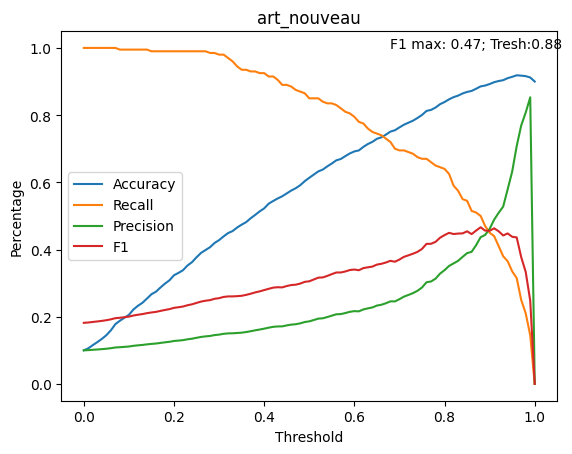

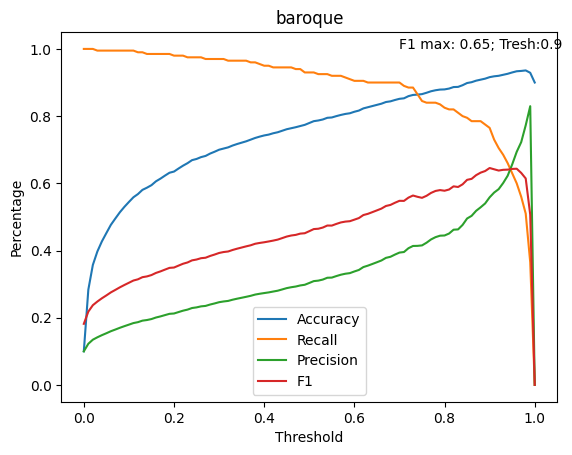

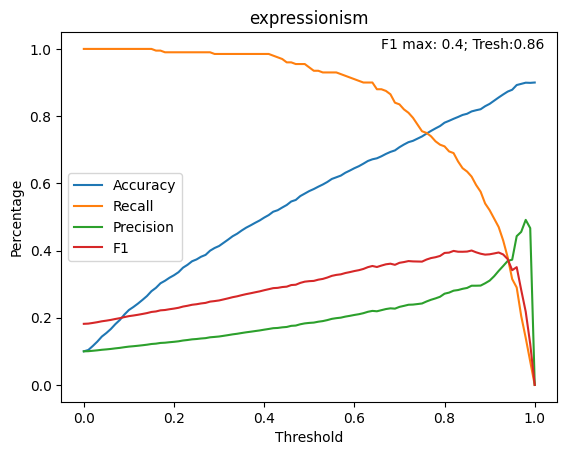

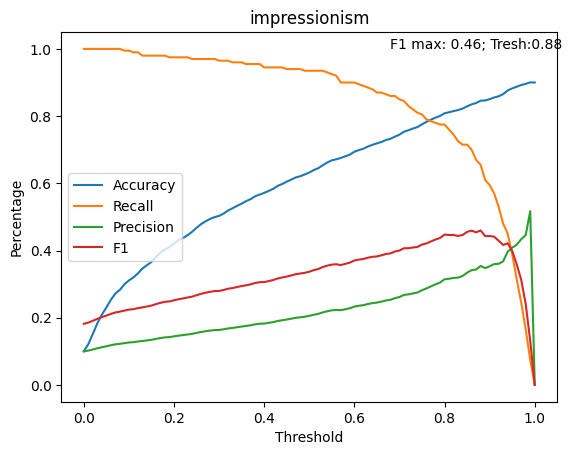

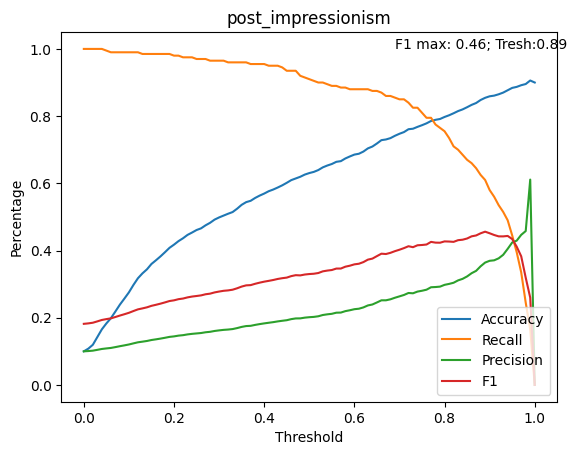

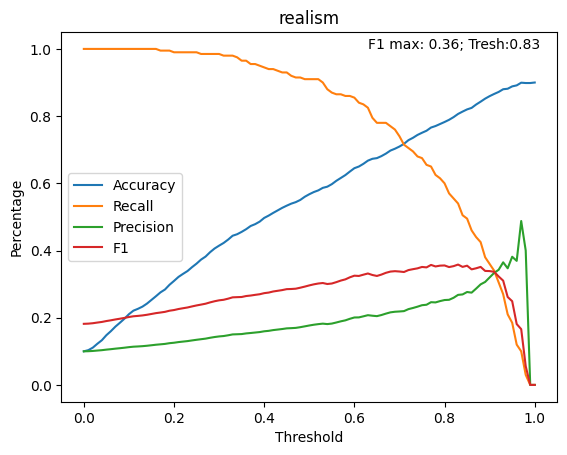

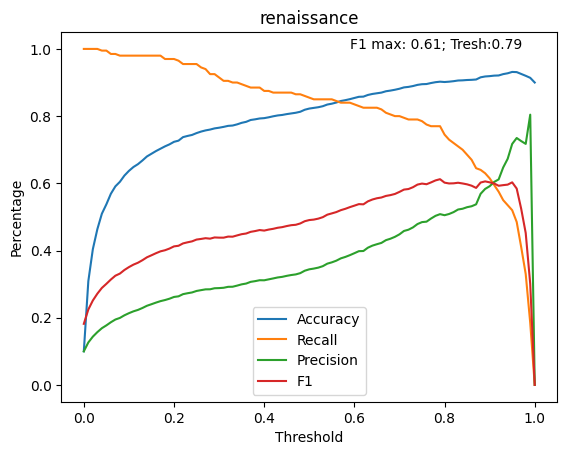

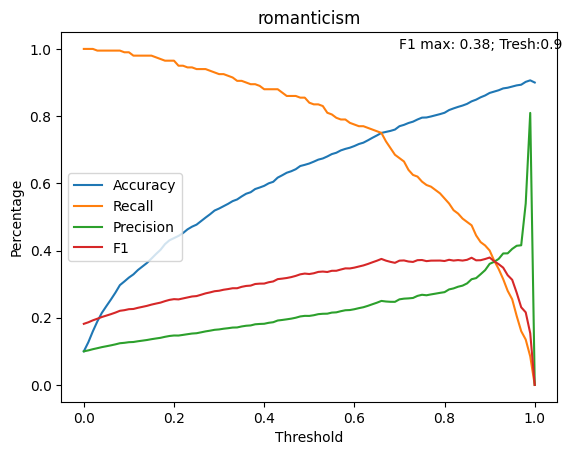

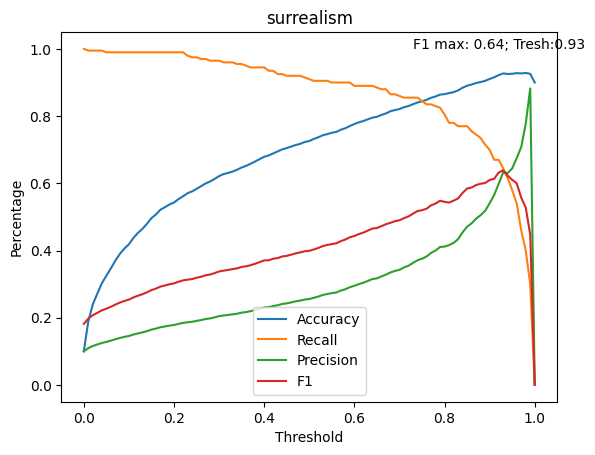

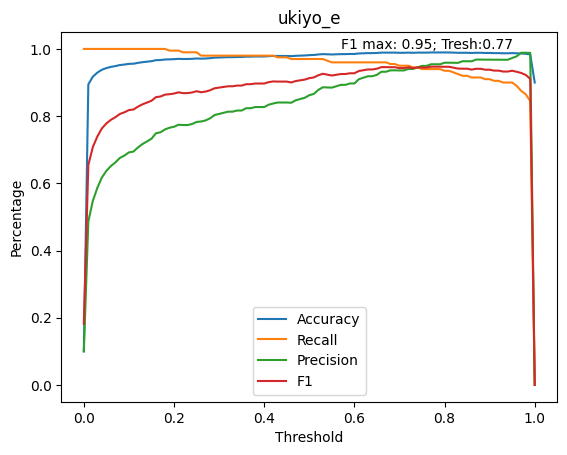

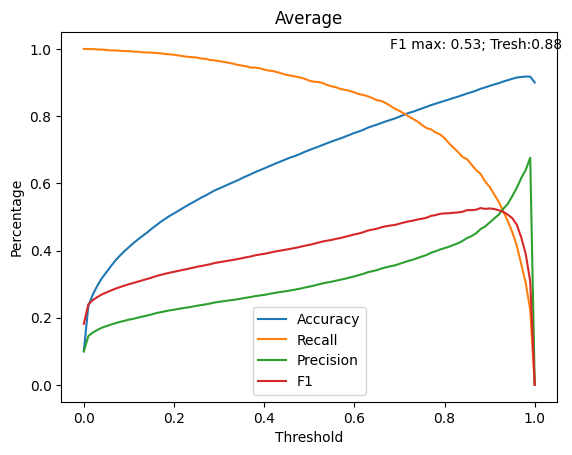

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy

accuracy_data = [[], [], [], [], [], [], [], [], [], [], []]
recall_data = [[], [], [], [], [], [], [], [], [], [], []]
precision_data = [[], [], [], [], [], [], [], [], [], [], []]
f1_data = [[], [], [], [], [], [], [], [], [], [], []]

tp_data = []
tn_data = []
fp_data = []
fn_data = []

for i in range(101):
  tp_data.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  tn_data.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  fp_data.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  fn_data.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

threshold_values = [i / 100 for i in range(101)]

for test_features, test_labels in validation_loader:
  # Generate predictions of the new batch
  output = model(test_features.to(device))
  prediction = torch.sigmoid(output).cpu().detach().numpy()

  # Determine batch confusion matrix and add to total

  for threshold in range(101):
    for classNr in range(len(classes)):
      tp, tn, fp, fn = determineConfusionMatrix(threshold / 100, prediction, test_labels, classNr, test_labels.size(0))
      tp_data[threshold][classNr] += tp
      tn_data[threshold][classNr] += tn
      fp_data[threshold][classNr] += fp
      fn_data[threshold][classNr] += fn

# Calculate all metrics
for threshold in range(101):

  average_accuracy = 0
  average_recall = 0
  average_precision = 0
  average_f1 = 0

  for classNr in range(len(classes)):
      accuracy, recall, precision, f1 = calculateMetrics(tp_data[threshold][classNr], tn_data[threshold][classNr], fp_data[threshold][classNr], fn_data[threshold][classNr])
      average_accuracy += accuracy
      average_recall += recall
      average_precision += precision
      average_f1 += f1

      accuracy_data[classNr].append(accuracy)
      recall_data[classNr].append(recall)
      precision_data[classNr].append(precision)
      f1_data[classNr].append(f1)

  accuracy_data[len(classes)].append(average_accuracy / len(classes))
  recall_data[len(classes)].append(average_recall / len(classes))
  precision_data[len(classes)].append(average_precision / len(classes))
  f1_data[len(classes)].append(average_f1 / len(classes))

# Plot the results
for classNr in range(len(classes) + 1):
  plt.title("Average" if classNr == len(classes) else classes[classNr])
  plt.plot(threshold_values, accuracy_data[classNr], label="Accuracy")
  plt.plot(threshold_values, recall_data[classNr], label="Recall")
  plt.plot(threshold_values, precision_data[classNr], label="Precision")
  plt.plot(threshold_values, f1_data[classNr], label="F1")
  F1xmax = threshold_values[numpy.argmax(f1_data[classNr])]
  F1ymax = round(max(f1_data[classNr]),2)
  plt.annotate("F1 max: " + str(F1ymax) + "; Tresh:" + str(F1xmax), xy=(F1xmax, F1ymax), xytext=(F1xmax - 0.2, 1.0))
  plt.legend(loc="best")
  plt.xlabel('Threshold')
  plt.ylabel('Percentage')
  plt.show()


In [ ]:
def determineConfusionMatrixMax(prediction, test_labels, classNr, batch_size):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  for imageNr in range(batch_size):
    result = torch.argmax(prediction[imageNr])
    if result == classNr:
      if test_labels[imageNr] == classNr:
        tp += 1
      else:
        fp += 1
    else:
      if test_labels[imageNr] != classNr:
        tn += 1
      else:
        fn += 1

  return tp, tn, fp, fn

In [ ]:
# Calculate metrics when picking maximum class value

import matplotlib.pyplot as plt
import math
import numpy

accuracy_data = [[], [], [], [], [], [], [], [], [], [], []]
recall_data = [[], [], [], [], [], [], [], [], [], [], []]
precision_data = [[], [], [], [], [], [], [], [], [], [], []]
f1_data = [[], [], [], [], [], [], [], [], [], [], []]

tp_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
tn_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fp_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fn_data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for test_features, test_labels in validation_loader:
  # Generate predictions of the new batch
  output = model(test_features.to(device))
  prediction = torch.sigmoid(output).cpu().detach()

  # Determine batch confusion matrix and add to total

  for classNr in range(len(classes)):
    tp, tn, fp, fn = determineConfusionMatrixMax(prediction, test_labels, classNr, test_labels.size(0))
    tp_data[classNr] += tp
    tn_data[classNr] += tn
    fp_data[classNr] += fp
    fn_data[classNr] += fn

# Calculate all metrics
average_accuracy = 0
average_recall = 0
average_precision = 0
average_f1 = 0

for classNr in range(len(classes)):
    accuracy, recall, precision, f1 = calculateMetrics(tp_data[classNr], tn_data[classNr], fp_data[classNr], fn_data[classNr])
    average_accuracy += accuracy
    average_recall += recall
    average_precision += precision
    average_f1 += f1

    accuracy_data[classNr] = accuracy
    recall_data[classNr] = recall
    precision_data[classNr] = precision
    f1_data[classNr] = f1

accuracy_data[len(classes)] = average_accuracy / len(classes)
recall_data[len(classes)] = average_recall / len(classes)
precision_data[len(classes)] = average_precision / len(classes)
f1_data[len(classes)] = average_f1 / len(classes)

# Plot the results
for classNr in range(len(classes) + 1):
  if classNr == len(classes):
    print("Average metrics: " )
  else:
    print(classes[classNr] + " metrics: " )
  print("Accuracy: " + str(accuracy_data[classNr]))
  print("Recall: " + str(recall_data[classNr]))
  print("Precision: " + str(precision_data[classNr]))
  print("F1: " + str(f1_data[classNr]))
  print()


art_nouveau metrics: 
Accuracy: 0.909
Recall: 0.45
Precision: 0.5555555555555556
F1: 0.4972375690607735

baroque metrics: 
Accuracy: 0.9335
Recall: 0.74
Precision: 0.6462882096069869
F1: 0.6899766899766899

expressionism metrics: 
Accuracy: 0.886
Recall: 0.46
Precision: 0.4339622641509434
F1: 0.44660194174757284

impressionism metrics: 
Accuracy: 0.8845
Recall: 0.47
Precision: 0.4292237442922374
F1: 0.4486873508353222

post_impressionism metrics: 
Accuracy: 0.8915
Recall: 0.49
Precision: 0.460093896713615
F1: 0.4745762711864407

realism metrics: 
Accuracy: 0.874
Recall: 0.345
Precision: 0.3631578947368421
F1: 0.35384615384615387

renaissance metrics: 
Accuracy: 0.9365
Recall: 0.66
Precision: 0.6910994764397905
F1: 0.6751918158567775

romanticism metrics: 
Accuracy: 0.9
Recall: 0.35
Precision: 0.5
F1: 0.4117647058823529

surrealism metrics: 
Accuracy: 0.9165
Recall: 0.72
Precision: 0.5647058823529412
F1: 0.6329670329670329

ukiyo_e metrics: 
Accuracy: 0.9895
Recall: 0.92
Precision: 0.97